In [1]:
import json
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import ipywidgets as widgets
from IPython.display import display, clear_output
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, roc_curve, auc
import warnings
import math

# Ignore warnings for cleaner output
warnings.filterwarnings("ignore")

In [2]:
# Helper Function
def beautify_bar_plot(dataframe, x_column, y_column):
    ax = dataframe.plot.bar(x=x_column, y=y_column, rot=0, color='skyblue', edgecolor='black', figsize=(10, 6))

    # Customize the plot
    ax.set_title(f'{y_column} Plot')
    ax.set_xlabel(x_column)
    ax.set_ylabel(y_column)
    ax.legend().set_title('Legend')

    # Add grid lines
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Customize the tick labels
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    # Add data labels above each bar
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=8)

    plt.show()


def combine_bins(temp_1, temp_2):
    l_2, r_2 = temp_2[0], temp_2[1]
    l_1, r_1 = temp_1[0], temp_1[1]
    n_1, n_2 = r_1 - l_1 + 1, r_2 - l_2 + 1
    s_1, s_2 = temp_1[2], temp_2[2]
    m_1, m_2 = temp_1[-1], temp_2[-1]
    n = n_1 + n_2

    if n == 2:
        m = (m_1 + m_2) / 2
    elif n_1 == 1:
        m = (m_1 + n_2 * m_2) / n
    elif n_2 == 1:
        m = (n_1 * m_1 + m_2) / n
    else:
        m = (n_1 * m_1 + n_2 * m_2) / n

    if n == 2:
        s = np.std([m_1, m_2], ddof=1)
    else:
        s = np.sqrt((n_1 * s_1 ** 2 + n_2 * s_2 ** 2) / n)

    return [min(l_1, l_2), max(r_1, r_2), s, m]

def p_value_cal(bin1, bin2, Class):
    m_1, m_2 = bin1[-1], bin2[-1]
    n_1 = bin1[1] - bin1[0] + 1
    n_2 = bin2[1] - bin2[0] + 1
    sd_1 = bin1[-2]
    sd_2 = bin2[-2]
    pooled_sd = ((n_1) * sd_1**2 + (n_2) * sd_2**2) / (n_1 + n_2 - 2)
    if pooled_sd > 0:
        z_value = (m_1 - m_2) / math.sqrt(pooled_sd *(1 / n_1 + 1 / n_2))
        p_value = 1 - norm.cdf(z_value)
    else:
        p_value = 2
    return p_value

def woe_iv(df, col, bins, target_col, sign):
    bins_x = pd.cut(df[col], bins, right=sign)
    binned_df_x = pd.DataFrame(bins_x)
    binned_df_x[target_col] = df[target_col]
    group_df_x = binned_df_x.groupby(col).agg(
        events=(target_col, 'sum'),
        total=(target_col, 'count')
    ).reset_index()
    group_df_x['non events'] = group_df_x['total'] - group_df_x['events']
    good_sum = group_df_x['non events'].sum()
    bad_sum = group_df_x['events'].sum()
    group_df_x['% of events'] = group_df_x['events'] / bad_sum
    group_df_x['% of non events'] = group_df_x['non events'] / good_sum
    group_df_x['WoE'] = np.log(group_df_x['% of non events'] / group_df_x['% of events'])
    WoEgood = np.where(~np.isinf(group_df_x['WoE']))[0]
    WoEmin = np.min(group_df_x['WoE'][WoEgood])
    WoEmax = np.max(group_df_x['WoE'][WoEgood])
    group_df_x['IV'] = group_df_x['WoE'] * (group_df_x['% of non events'] - group_df_x['% of events'])
    iv_val = group_df_x['IV'].sum()
    return group_df_x, iv_val

def generate_summary(dataset,column,y,sign):

    init_summary = dataset.groupby([column]).agg({y: ["mean", "std", "size"]}).rename(
        {"mean": "means", "size": "nsamples", "std": "std_dev"}, axis=1)

    init_summary.columns = init_summary.columns.droplevel(level=0)

    init_summary = init_summary[["means", "nsamples", "std_dev"]]
    init_summary = init_summary.reset_index()

    init_summary["del_flag"] = 0
    init_summary["std_dev"] = init_summary["std_dev"].fillna(0)

    init_summary = init_summary.sort_values([column], ascending=sign)

    return init_summary

def combine_bins_(summary):
    while True:
        i = 0
        summary = summary[summary.del_flag != 1]
        summary = summary.reset_index(drop=True)
        while True:

            j = i + 1

            if j >= len(summary):
                break

            if summary.iloc[j].means < summary.iloc[i].means:
                i = i + 1
                continue
            else:
                while True:
                    n = summary.iloc[j].nsamples + summary.iloc[i].nsamples
                    m = (summary.iloc[j].nsamples * summary.iloc[j].means +
                         summary.iloc[i].nsamples * summary.iloc[i].means) / n

                    if n == 2:
                        s = np.std([summary.iloc[j].means, summary.iloc[i].means], ddof=1)
                    else:
                        s = np.sqrt((summary.iloc[j].nsamples * (summary.iloc[j].std_dev ** 2) +
                                     summary.iloc[i].nsamples * (summary.iloc[i].std_dev ** 2)) / n)

                    summary.loc[i, "nsamples"] = n
                    summary.loc[i, "means"] = m
                    summary.loc[i, "std_dev"] = s
                    summary.loc[j, "del_flag"] = 1
                    j = j + 1
                    if j >= len(summary):
                        break
                    if summary.loc[j, "means"] < summary.loc[i, "means"]:
                        i = j
                        break
            if j >= len(summary):
                break
        dels = np.sum(summary["del_flag"])
        if dels == 0:
            break
    return summary

def fit(df, val):
    bins = json.loads(val[2])
    bins.insert(0, -np.inf)
    bins.append(np.inf)
    woe, iv = woe_iv(df, val[0], bins, 'Class', val[1])
    trans_pd = pd.DataFrame(pd.cut(df[val[0]], bins, right=val[1]))
    result = pd.merge(trans_pd, woe[[val[0],'WoE']], on=val[0], how='left').drop(columns = [val[0]]).rename(columns={'WoE':val[0]})
    return woe, iv, result

In [3]:
def binning(df,f, y, p_thresh, min_bin_size, ind_var_rate, sign):

    df_temp = df[[f,y]]
    df_temp = df_temp.sort_values(by=[f], ascending=sign)
    feature = df_temp[f].tolist()
    Class = df_temp[y].to_list()
    mean = df_temp[y].tolist()

    summary = generate_summary(df,f, y, sign)

    result = combine_bins_(summary)

    stack = []
    for i in range(0, len(feature)):
        curr_bin = [i, i, 0, mean[i]]
        if len(stack) == 0 or stack[-1][-1] > curr_bin[-1]:
            stack.append(curr_bin)
        else:
            prev_bin = stack.pop()
            stack.append(combine_bins(prev_bin, curr_bin))
            j = len(stack) - 2
            while True:
                if len(stack) == 1 or stack[j][-1] > stack[j + 1][-1]:
                    break
                else:
                    stack.append(combine_bins(stack.pop(), stack.pop()))
                    j -= 1

    sd_list = result['std_dev'].to_list()
    for i in range(0, len(stack)):
        stack[i][-2] = sd_list[i]

    while True:
        p_value_table = []
        for i in range(1, len(stack)):
            p_value = p_value_cal(stack[i-1], stack[i], Class)
            if (stack[i-1][1] - stack[i-1][0] + 1 < min_bin_size) or (sum(Class[stack[i-1][0]:stack[i-1][1]+1]) < ind_var_rate) or (stack[i][1] - stack[i][0] + 1 < min_bin_size) or (sum(Class[stack[i][0]:stack[i][1]+1]) < ind_var_rate):
                p_value = p_value + 1
            p_value_table.append([p_value,stack[i]])
        if len(p_value_table) > 0:
            max_val = (p_value_table[0][0], 0)
            for j in range(1, len(p_value_table)):
                if p_value_table[j][0] > max_val[0]:
                    max_val = (p_value_table[j][0], j)
            if max_val[0] > p_thresh:
                bin_1 = stack.pop(max_val[1])
                bin_2 = stack.pop(max_val[1])
                stack.insert(max_val[1],combine_bins(bin_1,bin_2))
            else:
                break
        else:
            break
    if sign:
        bins = [feature[i[1]] for i in stack]
        bins.insert(0,-np.inf)
        bins[-1] =  np.inf
    else:
        bins = [feature[i[0]] for i in stack]
        bins[0] = -np.inf
        bins.insert(-1, np.inf)
        bins.sort()

    print(bins)
    woe, iv =  woe_iv(df_temp,f,bins,target_col = y, sign = sign)
    return bins, woe, iv

In [4]:
df = pd.read_csv('train.csv')

In [5]:
X = df[df.columns[1:-1]]
y = df[['Class']]

In [6]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy=0.3)
X_re, y_re = smote.fit_resample(X, y)

In [7]:
# Perform the train-test split with a 70-30 ratio and stratify by the target variable
X_train, X_test, y_train, y_test = train_test_split(X_re, y_re, test_size=0.3, random_state=42, stratify=y_re)

In [8]:
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)
y_train = y_train.values.ravel()

In [ ]:
# cols = [("V2",False),("V3", True),("V10",True),("V14",True),("V18",False),("V17",False)]

In [ ]:
# sign = False
# dic_woe = {}
# p_thresh = 0.30
# min_bin_size = 7500
# ind_var_rate = 1
# event = 'Class'
# dic_woe = {}

# columns = ['Feature', 'Sign', 'Bins', 'IV']
# result_df = pd.DataFrame(columns=columns)

# for i in X_train.columns:
#     bins, woe, iv = binning(df_train,i[0], event , p_thresh, min_bin_size, ind_var_rate, i[1])
#     dic_woe[i[0]] = woe
#     display(woe)
#     print(iv)
#     beautify_bar_plot(woe,i[0],'WoE')
#     new_row_df = pd.DataFrame([[i[0], i[1], bins, iv]], columns=columns)
#     result_df = pd.concat([result_df, new_row_df], axis=0, ignore_index=True)

In [10]:
result_df_ = pd.read_csv('result_df_1.csv')

In [11]:
print(result_df_)

  Feature   Sign                                               Bins        IV
0      V2  False            [-0.0986779376837247, 1.18248816990071]  0.372850
1      V3   True  [-1.45597939171601, -1.00477029008895, -0.5720...  0.573060
2     V10   True  [-1.33584798796485, -0.680036661549588, -0.162...  0.520650
3     V14   True  [-1.45266598262744, -0.991595392268344, -0.788...  0.518742
4     V18  False  [-0.267826471412248, 0.166473111833407, 0.5399...  0.400202
5     V17  False  [0.331845882533011, 0.38956525490179, 0.811694...  0.276094


In [12]:
dic_woe = {}
X_train_trans = pd.DataFrame()
for i in range(0, result_df_.shape[0]):
    val = result_df_.loc[i].to_list()
    woe, iv, result = fit(df_train,val)
    dic_woe[val[0]] = woe
    X_train_trans = pd.concat([X_train_trans,result], axis=1)

In [13]:
 # Your data
data_v2 = dic_woe['V2']
data_v3 = dic_woe['V3']
data_v10 = dic_woe['V10']
data_v14 = dic_woe['V14']
data_v18 = dic_woe['V18']
data_v17 = dic_woe['V17']

# Dictionary to store data for each variable
data_dict = {'V2': data_v2, 'V3': data_v3, 'V10': data_v10, 'V14': data_v14, 'V18': data_v18, 'V17': data_v17}

# Dropdown widget
variable_dropdown = widgets.Dropdown(options=['V2', 'V3', 'V10', 'V14', 'V17', 'V18'], description='Feature:')

# Output widget to display data
output = widgets.Output()

# Function to update display based on dropdown value
def update_display(change):
    variable = variable_dropdown.value
    data = data_dict[variable]

    # Clear previous output
    with output:
        clear_output(wait=True)

        # Display new data
        df = pd.DataFrame(data)
        total_iv = df['IV'].sum()
        print(f"Total IV: {total_iv:.2f}")
        display(df)
        beautify_bar_plot(df, variable, 'WoE')

# Attach the function to the dropdown's value change event
variable_dropdown.observe(update_display, names='value')

# Initial display
display(variable_dropdown)
display(output)

Dropdown(description='Feature:', options=('V2', 'V3', 'V10', 'V14', 'V17', 'V18'), value='V2')

Output()

In [15]:
X_test_trans = pd.DataFrame()
for i in range(0, result_df_.shape[0]):
    val = result_df_.loc[i].to_list()
    result = fit(df_test,val)
    X_test_trans = pd.concat([X_test_trans,result[-1]], axis=1)

In [16]:
# Create a logistic regression model
model = LogisticRegression()

# Train the model
model.fit(X_train_trans, y_train)

LogisticRegression()

In [17]:
model.coef_

array([[-0.61105974, -0.55944434, -0.50062168, -0.40188717, -0.70476301,
        -0.25406952]])

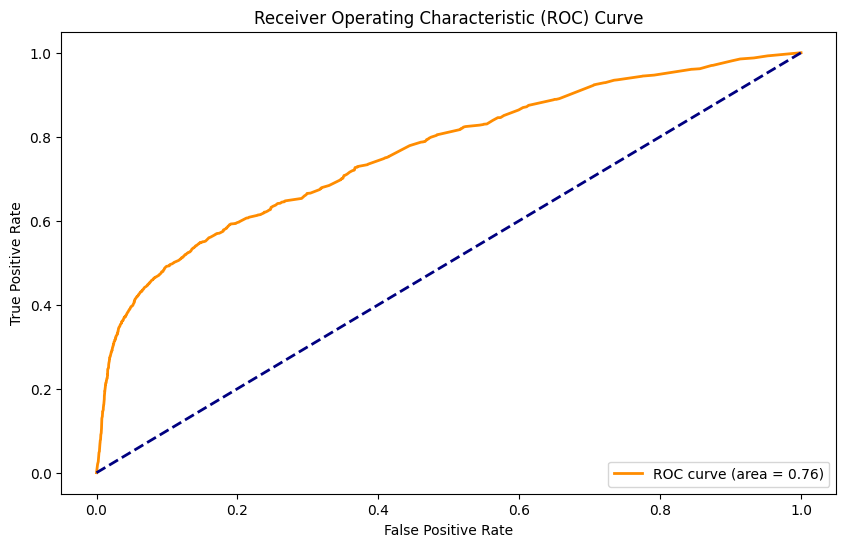

In [18]:
y_prob = model.predict_proba(X_test_trans)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [19]:
coefficients = model.coef_
df_woe = X_test_trans.copy()

# Offset and factor values
offset = 600
factor = 50

# Calculate log-odds for each row
log_odds = np.dot(df_woe.values, coefficients.T)

# Calculate credit scores for each row with higher scores indicating a higher likelihood of fraud
fraud_scores = offset - factor * log_odds

# Normalize scores to be within the range [0, 100]
max_fraud_score = np.max(fraud_scores)
min_fraud_score = np.min(fraud_scores)
normalized_fraud_scores = (fraud_scores - min_fraud_score) / (max_fraud_score - min_fraud_score) * 100

# Add the normalized fraud scores to the DataFrame
df_woe['Fraud_Score'] = normalized_fraud_scores

# Create buckets
bins = [0, 45, 75, 92, 100]
labels = ['No Risk', 'Low Risk', 'Moderate Risk', 'High Risk']
df_woe['Risk_Category'] = pd.cut(df_woe['Fraud_Score'], bins=bins, labels=labels, include_lowest=True)


# Create a donut chart with plotly
fig = px.pie(df_woe, names='Risk_Category', title='Fraud Risk Donut Chart', hole=0.7,
             color_discrete_sequence=px.colors.qualitative.Set3,
            # hover_data={'Risk_Category': True, 'Fraud_Score': False},
             labels={'Risk_Category': 'Fraud Risk'})

# Update the layout for better appearance
fig.update_traces(textinfo='percent+label', pull=[0.1, 0.1, 0.1, 0.1], hoverinfo='percent+name')

fig.update_layout(
    font=dict(family="Arial, sans-serif", size=12, color="RebeccaPurple"),
    legend=dict(title=dict(text='Risk Categories', side='top')),
    annotations=[dict(text='Fraud Risk', x=0.5, y=0.5, font_size=20, showarrow=False)],
    margin=dict(l=0, r=0, b=0, t=50),
    paper_bgcolor="whitesmoke",
)

# Show the figure
fig.show()

In [20]:
df_woe.tail(10)

,V2,V3,V10,V14,V18,V17,Fraud_Score,Risk_Category
85268,0.600474,0.449830,0.245194,-0.270457,0.648700,0.014469,93.984759,High Risk
85269,0.600474,-1.713636,0.334358,-0.270457,-0.748930,-0.946664,52.312397,Low Risk
85270,0.097104,0.449830,0.334358,0.297122,0.648700,0.301609,94.647796,High Risk
85271,0.097104,0.449830,0.245194,0.297122,0.648700,0.014469,92.601656,High Risk
85272,-1.168897,-1.713636,-1.602296,-2.163285,-1.025542,-0.946664,0.000000,No Risk
85273,0.097104,0.449830,0.334358,-0.547564,0.648700,0.282940,88.658341,Moderate Risk
85274,0.097104,0.449830,0.334358,0.297122,0.329630,0.282940,90.652430,Moderate Risk
85275,0.600474,-1.713636,0.245194,0.297122,0.329630,0.282940,74.167416,Low Risk
85276,0.600474,0.449830,0.245194,0.297122,0.329630,0.282940,95.227920,High Risk
85277,0.097104,0.449830,0.334358,0.297122,-0.440671,0.282940,81.206057,Moderate Risk
